In [1]:
import numpy as np # needed for the sm function
import pandas as pd # used for reading the data
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit as cf
from os import listdir
import statsmodels.api as sm #used to force regression line through origin
from os.path import isfile, join
import math

Code - not all of it is used in my project, but I felt it would be a waste to delete the unused parts.

In [2]:
# Define root and subdirectories
root_dir = 'C:/Users/daran/DATASET_FILES/'
this_dir = 'ISOTHERM_FILES/'

# Create a list of files in the specified directory
onlyfiles = [f for f in listdir(join(root_dir, this_dir)) if isfile(join(root_dir, this_dir, f))]

# Function to read a CSV file and return a Pandas DataFrame
def read(file):
    return pd.read_csv(join(root_dir, this_dir, file))

# Function to find unique MOF names from a list of files
def find_types(file_list):
    return list(set(file.split("_")[1] for file in file_list))

# Function to get gas data for a specific file
def gas(mof, gas, temp, field, charge, files):
    for file in files:
        if f"{mof}_{gas}_{temp}_{field}_{charge}" in file:
            return read(file).iloc[-1, 1]

# Function to analyze the maximum capacity of MOF for a requested gas at all 3 temperatures 
def analysis(field, charge, files, gas1):
    temp = [273, 298, 323]
    names = find_types(files)
    capacities = []
    
    for i in temp:
        temp_specific = []
        for name in names:
            temp_specific.append([name, gas(name, gas1, str(i), field, charge, files)])
        capacities.append(temp_specific)
    
    return capacities

# Function to filter files based on Charge type, forcefield, and temp.
def experiment(ct, ff, temp, files):
    return [file for file in files if ct in file and ff in file and temp in file]

# Function to perform Ordinary Least Squares (OLS) regression and return rsquared value and MOF
def LOBF(files, ct, ff, temp, gas):
    data = []
    
    for file in files:
        if gas in file and ct in file and ff in file and temp in file:
            result = sm.OLS(np.array(read(file).iloc[:, 0]), np.array(read(file).iloc[:, 1])).fit() 
            data.append([result.rsquared, file])
    
    return data


# Function to plot data using Matplotlib
def plot(pandafile, labels, title, legend, graph):
    plt.title(title)
    plt.xlabel(pandafile.columns[1])
    plt.ylabel(pandafile.columns[0])
    graph(pandafile.iloc[:, 0], pandafile.iloc[:, 1], label=labels) #iloc function allows me (here) to select columns
    if legend:
        plt.legend()

# Function to handle circular indexing
def looped_index(length, index):
    return 0 if index + 1 == length else index + 1

# Function to find versions of experiments performed on the inputted MOF(name)
def versions(files, name):
    version = []
    passed = False
    i = 0
    
    while not passed:
        if name in files[i]:
            version.append(files[i].split("_")[-2:])
            if i == len(files) - 1:
                passed = True
            elif name not in files[i + 1]:
                passed = True
        i += 1
    
    for i in version:
        i[1] = i[1][:-4]
    
    return version, len(version)

# Function to sort data using bubble sort
def sort(data, x):
    values = [i[x] for i in data]
    values1 = sorted(values)
    return([next((i for i in data if i[x] == val), None) for val in values1])

# Function to fit Langmuir equation and plot the result
def langmuir_fit(file, plot, temp):
    x_data = np.array(read(file).iloc[:, 0])
    y_data = np.array(read(file).iloc[:, 1])
    a = max(y_data)
    
    def langmuir(x, b):
        return (x * a) / (b + x)

    param, _ = curve_fit(langmuir, x_data, y_data) # this obtains the optimal value b to input so that the langmuir function fits the data
    b = param
    
    y_fit = langmuir(read(file).iloc[:, 0], b)
    ss_total = np.sum((y_data - np.mean(y_data))**2)
    ss_residual = np.sum((y_data - y_fit)**2)
    
    # R^2 calculation
    r_squared = 1 - (ss_residual / ss_total) if ss_total != 0 else np.nan
    
    if plot:
        plt.scatter(x_data, y_data, label='Original Data')
        plt.plot(x_data, y_fit, label='Fitted Langmuir Curve', color='green')
        plt.legend()
        plt.xlabel(read(file).columns[1])
        plt.ylabel(read(file).columns[0])
        plt.title(f'{file.split("_")[1]} {temp}')
        plt.show()

    return r_squared

# Function to compute Langmuir rsquared values for specified conditions
def langmuir_rsquared(files, gas, temp, ff, ct):
    data1 = [(file, langmuir_fit(file, False, temp)) for file in files if ff in file and gas in file and temp in file and ct in file]
    return data1

# Function to plot data together
def plot_together(names, n, ct, ff):
    data = ""
    MOF = "ACOLIP"
    (data, length) = versions(onlyfiles, f'{ct}_{MOF}_{ff}')
    index = 0
    count = 0
    
    for i in names[:n]:
        MOF = i
        count = 0
        for file in onlyfiles:
            if 'DDEC' in file and 'UFF' in file and i in file:
                this_df = read(file)  # Extracts file
                plot(this_df, f'{data[index][0]} {data[index][1]}', MOF, True, plt.scatter) 
                print(length)# Datafile, labels, title, legend, graph type
                index = looped_index(length, index)
                count += 1
            if count == length:
                break  # Reduces wasted processing
        plt.grid(True)
        plt.show()

# Function to plot requested data
def plot_requested(MOF, ct, ff):
    (data, length) = versions(onlyfiles, f'{ct}_{MOF}_{ff}')
    index = 0
    count = 0
    for file in onlyfiles:
        if ff in file and ct in file and MOF in file:
            this_df = read(file)
            plot(this_df, f'{data[index][0]} {data[index][1]}', MOF, True, plt.plot)
            index = looped_index(length, index)            
            count += 1
        if count == length:
            break
    plt.grid(True)
    plt.show()


## Project: comparing how UFF and DREIDING rank linearity

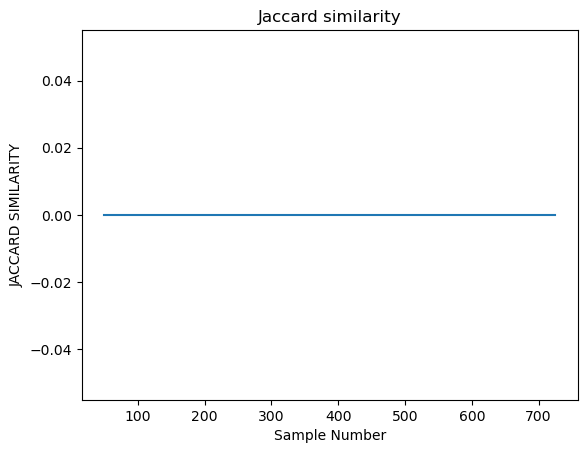

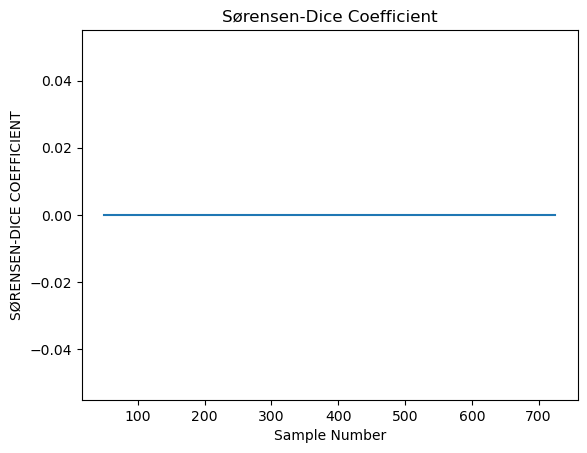

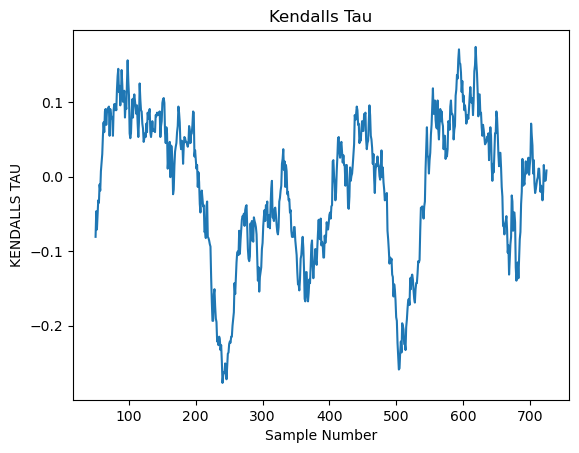

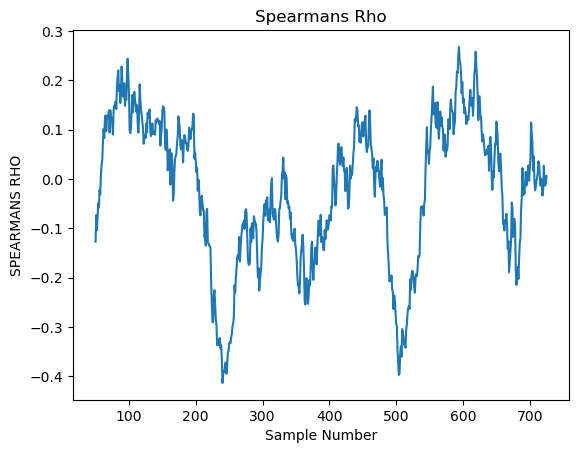

In [6]:
mostlinearUFF = ([i[1] for i in sort(LOBF(onlyfiles, "DDEC", "_UFF_", "273", "CO2"),0)]) 
mostlinearDREIDING = ([i[1] for i in sort(LOBF(onlyfiles, "DDEC", "DREIDING", "273", "CO2"),0)])
mostlinearUFF.reverse(), mostlinearDREIDING.reverse()
from scipy.stats import kendalltau, spearmanr

# Jaccard Similarity
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    
    if union == 0:
        return 0  # Return 0 if the union is empty
    
    similarity = intersection / union
    return similarity

# Sørensen-Dice Coefficient
def sorensen_dice_coefficient(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    
    intersection = len(set1.intersection(set2))
    size_set1 = len(set1)
    size_set2 = len(set2)
    
    if size_set1 + size_set2 == 0:
        return 0  # Return 0 if both sets are empty
    
    coefficient = 2 * intersection / (size_set1 + size_set2)
    return coefficient

# Kendall's Tau
def kendalls_tau(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Lists must have the same length")

    tau, _ = kendalltau(list1, list2)
    return tau

# Spearman's Rank Correlation Coefficient


def spearmans_rho(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Lists must have the same length")

    rho, _ = spearmanr(list1, list2)
    return rho

def comparison_graphs(): #plots 4 graphs for each of the comparisons as defined in the functions before
    similarity = []
    x = []
    n=50
    for ii in range(4):
        functions = [jaccard_similarity, sorensen_dice_coefficient, kendalls_tau, spearmans_rho]
        versions = ["Jaccard similarity", "Sørensen-Dice Coefficient", "Kendalls Tau", "Spearmans Rho" ]
        for i in range(n, len(mostlinearUFF)):
            rho= functions[ii](mostlinearUFF[i-n:i], mostlinearDREIDING[i-n:i])
            similarity.append(rho)
            x.append(i)
        plt.plot(x, similarity)
        plt.ylabel(versions[ii].upper())
        plt.xlabel("Sample Number")
        plt.title(versions[ii])
        plt.show()
        similarity = []
        x = []
comparison_graphs()


In [7]:

def find_MOF_index(MOF, data): 
    return [i for i in range(len(data)) if MOF in data[i]][0]
print(find_MOF_index("ASALIP", mostlinearUFF), find_MOF_index("ASALIP", mostlinearDREIDING))

0 36
